In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
data_path = './GANdata'
os.makedirs(data_path, exist_ok=True)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_ds = datasets.MNIST(data_path, train=True, transform=transform, download=True)

In [7]:
train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [8]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

#for check

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [9]:
# Generator

class Generator(nn.Module):
    def __init__(self, nz, img_size):
        super(Generator, self).__init__()
        self.nz = nz # 100, get noise vector of size 100 -> image. This is a simple model
        self.img_size = img_size # 1 x 28 x 28
        
        self.model = nn.Sequential(
            nn.Linear(self.nz, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(np.prod(self.img_size))),
            nn.Tanh()
        )
    
    def forward(self, z):
        output = self.model(z)
        image = output.reshape(output.shape[0], *self.img_size) # unpacking + batch
        return image

In [10]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
    
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        x = img.reshape(img.shape[0], -1)
        output = self.model(x)
        return output

In [11]:
# check
z = torch.randn(16,100).to(device) # random noise
model_gen = Generator(100, (1, 28, 28)).to(device)
output = model_gen(z)
print(output.shape)

x = torch.randn(16,1,28,28).to(device)
model_dis = Discriminator((1, 28, 28)).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16, 1])


In [12]:
def initialize_model(model):
    classname = model.__class__.__name__ # module name?
    print(classname)
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)


model_gen.apply(initialize_model)
model_dis.apply(initialize_model)
'''
Applies fn recursively to every submodule (as returned by .children()) as well as self. 
Typical use includes initializing the parameters of a model (see also torch.nn.init).
'''

Linear
LeakyReLU
Linear
BatchNorm1d
LeakyReLU
Linear
BatchNorm1d
LeakyReLU
Linear
BatchNorm1d
LeakyReLU
Linear
Tanh
Sequential
Generator
Linear
LeakyReLU
Linear
LeakyReLU
Linear
Sigmoid
Sequential
Discriminator


'\nApplies fn recursively to every submodule (as returned by .children()) as well as self. \nTypical use includes initializing the parameters of a model (see also torch.nn.init).\n'

In [14]:
loss_fcn = nn.BCELoss()
# - (y_n * log(x_n) + (1 - y_n) * log(1 - x_n))
# y_n에 real / fake label, x_n에 discriminator의 output을 넣어서 의도한 loss를 구하기

In [15]:
from torch import optim # for optimization

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_D = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1, beta2))
opt_G = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1, beta2))

In [16]:
real = 1
fake = 0
nz = 100
num_epoch = 100
loss_log = {'gen': [], 'dis': []}

In [18]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epoch):
    for x_batch, y_batch in train_dataloader:
        batch_size = len(x_batch)
        x_batch = x_batch.to(device)
        y_batch_r = torch.ones((batch_size, 1)).to(device)
        y_batch_f = torch.zeros((batch_size, 1)).to(device)
        
        # Generator step
        model_gen.zero_grad()
        noise = torch.randn(batch_size, nz, device=device)
        output_gen = model_gen(noise)
        output_dis = model_dis(output_gen)
        loss_gen = loss_fcn(output_dis, y_batch_r) # maximize log(D(G(z))), 본래는 log(1 - D(G(z)))를 minimize긴 한데 충분한 변화가 아님
        loss_gen.backward()
        opt_G.step()
        
        # Discriminator step
        model_dis.zero_grad()
        output_dis_real = model_dis(x_batch)
        output_dis_fake = model_dis(output_gen.clone().detach())
        loss_real = loss_fcn(output_dis_real, y_batch_r) # maximize log(D(x))
        loss_fake = loss_fcn(output_dis_fake, y_batch_f) # maximize 1 - log(D(G(z)))
        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_D.step()
        
        loss_log['gen'].append(loss_gen.item())
        loss_log['dis'].append(loss_dis.item())
        
        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))
        
        

Epoch: 0, G_Loss: 2.248571, D_Loss: 0.343581, time: 0.13 min
Epoch: 1, G_Loss: 1.373024, D_Loss: 0.184527, time: 0.27 min
Epoch: 1, G_Loss: 1.489920, D_Loss: 0.439714, time: 0.41 min
Epoch: 2, G_Loss: 2.860862, D_Loss: 0.482628, time: 0.55 min
Epoch: 2, G_Loss: 2.048623, D_Loss: 0.299608, time: 0.68 min
Epoch: 3, G_Loss: 3.279032, D_Loss: 0.380393, time: 0.82 min
Epoch: 3, G_Loss: 2.515978, D_Loss: 0.238160, time: 0.96 min
Epoch: 4, G_Loss: 2.053371, D_Loss: 0.187470, time: 1.10 min
Epoch: 4, G_Loss: 0.770059, D_Loss: 0.379480, time: 1.24 min
Epoch: 5, G_Loss: 3.380693, D_Loss: 0.547626, time: 1.38 min
Epoch: 5, G_Loss: 2.982160, D_Loss: 0.173397, time: 1.52 min
Epoch: 6, G_Loss: 2.263862, D_Loss: 0.158739, time: 1.66 min
Epoch: 6, G_Loss: 1.545429, D_Loss: 0.268927, time: 1.79 min
Epoch: 7, G_Loss: 3.167553, D_Loss: 0.144705, time: 1.93 min
Epoch: 7, G_Loss: 5.774007, D_Loss: 0.742368, time: 2.07 min
Epoch: 8, G_Loss: 2.708421, D_Loss: 0.273394, time: 2.21 min
Epoch: 9, G_Loss: 1.4093

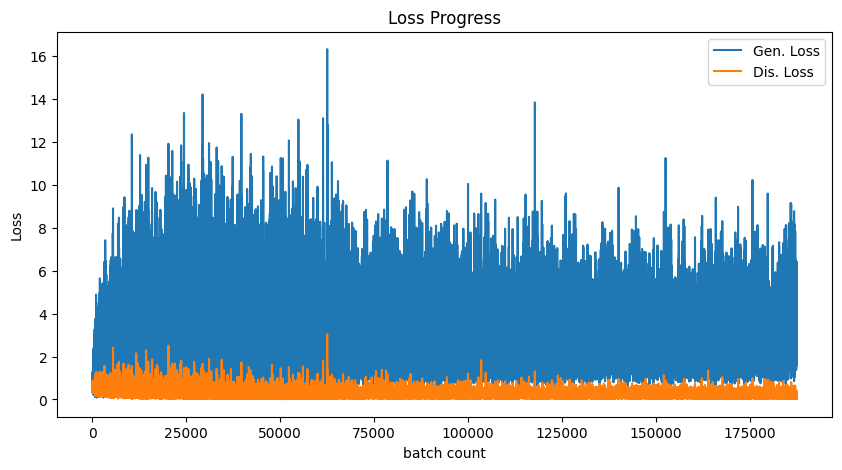

In [19]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_log['gen'], label='Gen. Loss')
plt.plot(loss_log['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
save_path = './models'
os.makedirs(save_path, exist_ok=True)
torch.save(model_dis.state_dict(), save_path+'/discriminator.pt')
torch.save(model_gen.state_dict(), save_path+"/generator.pt")

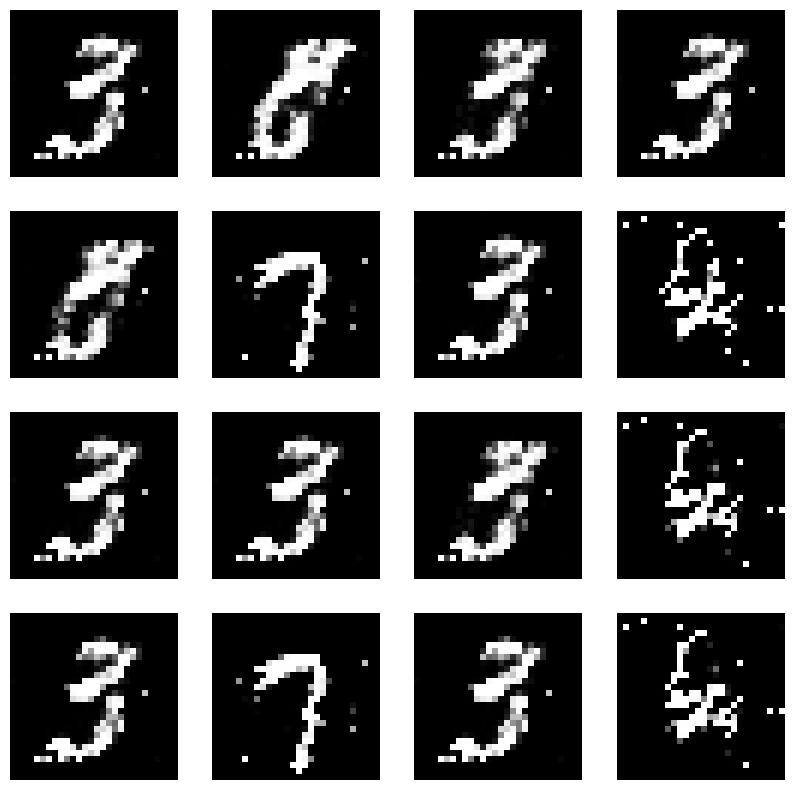

In [21]:
model_gen.eval()

with torch.no_grad():
    new_noise = torch.randn(16, 100, device=device)
    result = model_gen(new_noise).clone().detach().cpu()

plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*result[ii]+0.5),cmap='gray')
    plt.axis('off')

In [13]:
print(device)

cuda
